<h2 align=center> Fine-Tune BERT for Classifying Sarcastic News Headlines with TensorFlow</h2>

- To fine-tune BERT, we need to use a GPU since it's computationally expensive.
- The authors recommend fine tuning with a small learning rate and only 2-4 epochs not to change BERT's parameters drastically in the [original paper](http://https://arxiv.org/abs/1810.04805).
- For this simple dataset, we can obtain validation AUC > 93% with only one epoch that takes about 15 minutes on Nvidia Tesla P100.

# 1) Load packages

In [1]:
import os 
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import json

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


---

# 2) Walk through the directory and fetch the model, preprocessor, and dataset.

In [2]:
# expected paths
encoder_path = '/kaggle/input/bert/tensorflow2/bert-en-uncased-l-12-h-768-a-12/2/'
preprocessor_path = '/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/'

### 2.1) Load the dataset and check the model's path

In [3]:
# boolean flags for checking the path once
encoder_found = False
preprocessor_found = False

# walk through the directiory
for dirname, _, filenames in os.walk('/kaggle/input/'):
    # for every file, look for the .json dataset
    for filename in filenames:
        print(os.path.join(dirname,filename))
        if filename=='Sarcasm_Headlines_Dataset_v2.json':
            data_json_path = os.path.join(dirname,filename)
            print("\nDataset loaded! \n")
    # is the encoder dir present?
    if encoder_path in dirname and not encoder_found:
        print("\nBERT encoder found! \n")
        encoder_found = True
    # is the preprocessor dir present?
    if preprocessor_path in dirname and not preprocessor_found:
        print("\nBERT preprocessor found! \n")
        preprocessor_found = True
            

/kaggle/input/bert/tensorflow2/bert-en-uncased-l-12-h-768-a-12/2/saved_model.pb
/kaggle/input/bert/tensorflow2/bert-en-uncased-l-12-h-768-a-12/2/keras_metadata.pb
/kaggle/input/bert/tensorflow2/bert-en-uncased-l-12-h-768-a-12/2/assets/vocab.txt

BERT encoder found! 

/kaggle/input/bert/tensorflow2/bert-en-uncased-l-12-h-768-a-12/2/variables/variables.index
/kaggle/input/bert/tensorflow2/bert-en-uncased-l-12-h-768-a-12/2/variables/variables.data-00000-of-00001
/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/saved_model.pb
/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/keras_metadata.pb
/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/assets/vocab.txt

BERT preprocessor found! 

/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/variables/variables.index
/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/variables/variables.data-00000-of-00001
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json

Dataset loaded! 

/kagg

### 2.2) Import the .jSON dataset as a pandas dataframe

In [4]:
import json
data = []

# pen the file and read line by line
with open(data_json_path, 'r') as file:
    for line in file:
        # parse each line as a JSON object and append to the list
        data.append(json.loads(line))

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data)

In [5]:
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


---

# 3) Clean the dataset and inspect for imbalances 

In [6]:
# drop article link and rename the label
clean_df = df.drop('article_link', axis=1)
clean_df.rename(columns={'is_sarcastic': 'label'}, inplace=True)

In [7]:
# any null values?
clean_df.label.isnull().sum()

0

In [8]:
# waht's the distrubtion of the data?
clean_df.describe()

,label
count,28619.000000
mean,0.476397
std,0.499451
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


### 3.1) Visualize the labels

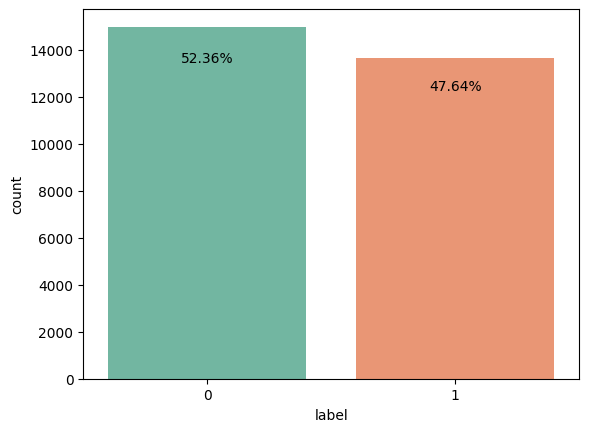

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x='label', data=clean_df, palette='Set2')
ax = plt.gca()
total = len(df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, 
            0.9*height,
            '{:1.2f}%'.format((height/total)* 100),
            ha='center')

- The dataset is slightly imbalance and should not be an issue.

### 3.2) What's the distrubtion of sentence length?

- Based on the results, we can limit our maximum sequence length in BERT.


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):



 The maximum length of headline is 151


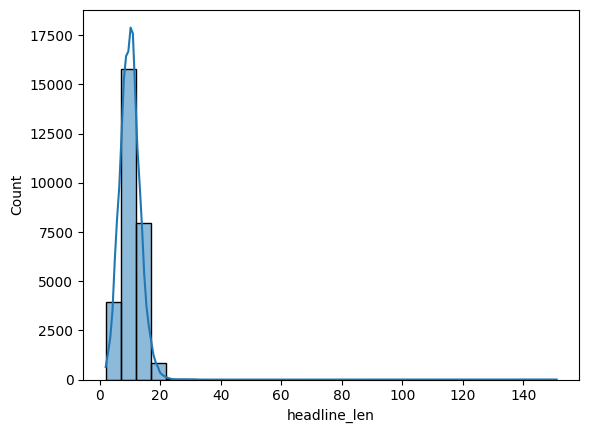

In [10]:
# what's the distrubtion of sentence length?
clean_df['headline_len'] = clean_df['headline'].apply(lambda x : len(x.split()))
sns.histplot(x=clean_df['headline_len'], bins=30, kde=True)

print(f"\n The maximum length of headline is {max(clean_df['headline_len'])}")

- Since the maximum seq_length is 151, we will set the preprocessor to take in to 200 tokens to give it a breather for word piece tokenization, start with[CLS] and end with [SOP] tokens.
- Ideally we should use 256 since BERT splits some words in multiple token but we will run out of memory.

In [11]:
seq_length = 200

---

# 4) Split the data and create input pipelines

- Given the size of the data, 90% (~26k data points) should suffice given that BERT is already pre-trained.

### 4.1) Split the training and validation data

In [12]:
from sklearn.model_selection import train_test_split
# let's split the data into train and validation sets with stratification to keep the original ratio of classes
train_df, valid_df = train_test_split(clean_df, random_state=42, train_size=0.9, stratify=clean_df.label.values)
train_df.shape, valid_df.shape

((25757, 3), (2862, 3))

### 4.2) Create input piplelines utilizing the CPU

In [13]:
train_batch_size = 16
with tf.device('/cpu:0'):
    train_data = tf.data.Dataset.from_tensor_slices(
        (train_df['headline'].values, train_df['label'].values)
    )
    
    valid_data = tf.data.Dataset.from_tensor_slices(
        (valid_df['headline'].values, valid_df['label'].values)
    )
    # shuffle, batch, and autotune the prefetch method to avoid bottlenecks
    train_data = train_data.shuffle(1000).batch(train_batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
    valid_data = valid_data.batch(train_batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

- This input pipelines help with streaming the data rather than forcing it all in our memory. This is needed given that Kaggle's memory is limited.
- The pipelines also makes use of the CPU to handle the data so we can allocate the GPU strtictly for training and maximize usage of resources. This way, the CPU will be responsible for preparing the training data and minimize the wait time for processing new data.
- After experimentation, any batch size > 16 uses more RAM that kaggle offers. Hence, we use 16. It will take longer to train 1 epoch but might converge faster since the gradients update often.

In [14]:
# are the inputs compatible with tensorflow?
print(train_data.element_spec)
print(valid_data.element_spec)

(TensorSpec(shape=(16,), dtype=tf.string, name=None), TensorSpec(shape=(16,), dtype=tf.int64, name=None))
(TensorSpec(shape=(16,), dtype=tf.string, name=None), TensorSpec(shape=(16,), dtype=tf.int64, name=None))


In [15]:
# is the dataset object correct?
for text, label in train_data.take(1):
    print(f'text = {text}, label = {label}')
    #model.call(print(text[0]))

text = [b'area plant proudly displays leaf'
 b'soldier hoping we invade someplace tropical next'
 b"to stop police shootings, we need to move beyond 'bad cops'"
 b'video game henchmen plan meetup around explosive barrels'
 b'u.s. improves infrastructure with transnational power strip'
 b'new poll finds americans view death of close relative more favorably than congress'
 b'unpopped kernels costing u.s. billions'
 b'scalia bundles up in fur robe in preparation for d.c. blizzard'
 b"community vastly improved by tv station's caring"
 b'god admits he was in pretty bad place while creating universe'
 b"newborn soothed by familiar sound of parents' bickering"
 b'trump campaign ponders going negative'
 b'police arrest two men in brazil gang-rape case'
 b'how a traveling consultant helps america hide the homeless'
 b"'wild thing' charlie sheen wants to throw out first pitch for world series"
 b'local fabric store urges you to check them out on twitter'], label = [1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 

#### The inputs are compatible with tensorflow2!
---

# 5) Fetch pre-trained BERT and its preprocessor from the model garden

### 5.1) Load BERT

In [16]:
import tensorflow_text # need for preprocessor

bert_encoder = hub.KerasLayer(
    "/kaggle/input/bert/tensorflow2/bert-en-uncased-l-12-h-768-a-12/2/",
    trainable=True) 
bert_preprocessor = hub.load("/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/")


- Load the encoder as KerasLayer.
- Load the preprocessor model using .load() method as we need to modify the seq_length before using it as a layer since BERT's default is 128 token.

###  5.2) Preprocessing pipeline

In [17]:
class BertPreprocessor:
    
    """
    BertPreprocessor prepares the text data for BERT model training 
    and inference by tokenizing and modifying the sequence length.

    Attributes:
        seq_length (int): The fixed sequence length for BERT inputs.
        preprocessor: The preprocessor layer from BERT TensorFlow Hub.
        tokenize: Keras layer to tokenize the inputs.
        pack_inputs: Keras layer to pack tokenized inputs into the format 
                     expected by BERT.
                     
    """
    def __init__(self, preprocessor, seq_length):
        
        """
        Initializes the BertPreprocessor with a specific sequence length and pre-loaded 
        preprocessor.

        """
        
        self.seq_length = seq_length
        self.preprocessor = preprocessor
        
        # grab the tokenization layer from the preprocessor.
        self.tokenize = hub.KerasLayer(self.preprocessor.tokenize)
        # we use pack_inputs to modify the default sequence length
        self.pack_inputs = hub.KerasLayer(
            self.preprocessor.bert_pack_inputs,
            arguments=dict(seq_length=seq_length))

    def preprocess(self, texts):
        
        """
        Preprocesses the given text inputs for BERT by tokenizing and 
        packing the sequences.
        
        Args:
            texts: A batch of text inputs to be preprocessed.
            
        Returns:
            The packed encoder inputs suitable for input to BERT.
            
        """
        
        # tokenize the texts
        tokenized_texts = self.tokenize(texts)
        # pack the tokenized texts
        encoder_inputs = self.pack_inputs([tokenized_texts])
        
        return encoder_inputs


#### Is it working?

In [19]:
test_preprocessor = BertPreprocessor(bert_preprocessor, seq_length=seq_length)
test_preprocessor.preprocess(['Test test, is there anybody out there?'])

{'input_word_ids': <tf.Tensor: shape=(1, 200), dtype=int32, numpy=
 array([[  101,  3231,  3231,  1010,  2003,  2045, 10334,  2041,  2045,
          1029,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     

#### Great!

### 5.3) Building the Classifier

In [20]:
class BertClassifier(tf.keras.Model):
    """
    BertClassifier is a model that combines a BERT preprocessor and a BERT encoder
    with a classification layer on top. It takes raw text inputs,
    preprocess them into the format expected by BERT, obtain the encoded representations,
    and predict the class of the input texts using a simple neural network layer.

    Attributes:
        seq_length (int): The fixed sequence length expected by the BERT model.
        preprocessor (BertPreprocessor): An instance of the BertPreprocessor class for text preprocessing.
        encoder: The BERT encoder from TensorFlow Hub.
        dropout (tf.keras.layers.Dropout): Dropout layer to prevent overfitting.
        classifier (tf.keras.layers.Dense): Output layer for classification.
    """
    def __init__(self, preprocessor, encoder, seq_length):
        """
        Initializes BertClassifier.
        
        """
        super(BertClassifier, self).__init__()
        # initialize the preprocessor pipeline with the given sequence length
        self.seq_length = seq_length
        self.preprocessor = BertPreprocessor(preprocessor, self.seq_length)
        # Initialize BERT encoder
        self.encoder = encoder
        
        # a additional layers
        self.dropout = tf.keras.layers.Dropout(0.2, name='dropout_layer')
        self.dense = tf.keras.layers.Dense(3, activation='tanh', name='dense')
        self.classifier = tf.keras.layers.Dense(1, activation='sigmoid', name='sigmoid_output')

    def call(self, inputs):
        """
        Processes raw text through the model pipeline: Preprocessing, encoding, 
                                                        and classifying.

        Args:
            inputs: A batch of raw text inputs.

        Returns:
            The predicted probabilities or classifications for the inputs.
        """
        # Preprocess inputs
        encoder_inputs = self.preprocessor.preprocess(inputs)
    
        # obtain BERT encoder outputs
        encoder_outputs = self.encoder(encoder_inputs)
        # "pooled_output" represents the entire sequence's representation 
        # which is typically used for classification tasks.
        pooled_output = encoder_outputs["pooled_output"]
        
        # avoid overfitting
        x = self.dropout(pooled_output) 
        x = self.dropout(x)
        
        return self.classifier(x)


- We have built the model pipelines that we need to train.
- The model takes raw text and preprocess it into the format BERT requires.

#### Is it working well?

In [21]:
# intialize an instance
model = BertClassifier(bert_preprocessor, bert_encoder, seq_length=256)


In [22]:
# initialize the model by predicting the output of a training batch
for text, label in train_data.take(1):
    print(model.predict(text))

1/1 [==============================] - 4s 4s/step
[[0.48547342]
 [0.5040093 ]
 [0.5554815 ]
 [0.5122942 ]
 [0.45835492]
 [0.51041687]
 [0.45328027]
 [0.42211893]
 [0.6839672 ]
 [0.5120942 ]
 [0.65594476]
 [0.5741547 ]
 [0.882621  ]
 [0.8152109 ]
 [0.78437036]
 [0.30528724]]


#### Looks Great!
---

### 6) Training the Model

In [23]:
model.summary()

Model: "bert_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    multiple                  109482241 
                                                                 
 dropout_layer (Dropout)     multiple                  0         
                                                                 
 dense (Dense)               multiple                  0 (unused)
                                                                 
 sigmoid_output (Dense)      multiple                  769       
                                                                 
Total params: 109483010 (417.64 MB)
Trainable params: 109483009 (417.64 MB)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________


#### 6.1) Complie the Model

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5
                                                 ),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy'])

- We employ the Adam optimizer with a low learning rate, as advised, to preserve the pre-trained weights without significant alteration.

- Since the classes are slighly imbalanced, AUC is a better metric than accuracy, we will monitor it instead

In [25]:
#Train model

epochs = 2

metric ='val_auc'
callback_list = [ 
                 tf.keras.callbacks.EarlyStopping(monitor=metric,
                                                  patience= 1,
                                                  restore_best_weights=True)
                ]

history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=epochs,
                   batch_size=train_batch_size,
                   callbacks=[callback_list]) 

Epoch 1/2
1609/1609 [==============================] - 903s 536ms/step - loss: 0.2866 - auc: 0.9498 - accuracy: 0.8752 - val_loss: 0.1849 - val_auc: 0.9786 - val_accuracy: 0.9266
Epoch 2/2
1609/1609 [==============================] - 858s 534ms/step - loss: 0.1428 - auc: 0.9868 - accuracy: 0.9463 - val_loss: 0.2077 - val_auc: 0.9825 - val_accuracy: 0.9213


### 7) Evaluate the Model

In [55]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    train_met = history.history[metric]
    valid_met = history.history['val_'+metric]
    epochs = list(range(1,len(train_met)+1))
    plt.plot(epochs, train_met) 
    plt.plot(epochs, valid_met, '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

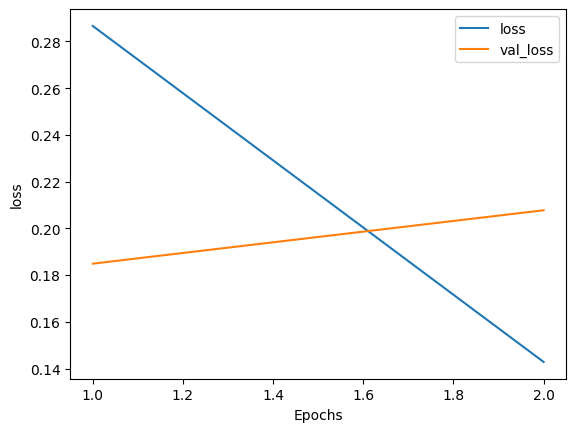

In [56]:
plot_graphs(history, 'loss')

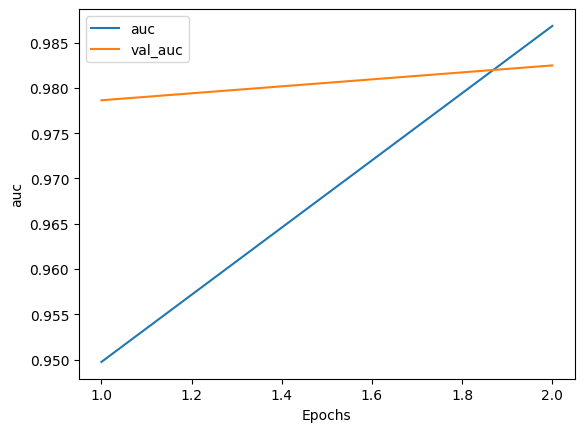

In [57]:
plot_graphs(history, 'auc')

### 7.1) ROC and AUC score

In [100]:
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, recall_score, precision_score, accuracy_score, confusion_matrix

In [81]:
# prepare the labls and headlines for evaluation 
valid_labels = valid_df.label.to_numpy()
valid_headlines = valid_df.headline.to_numpy()
y_pred_probs = model.predict(valid_headlines)

90/90 [==============================] - 32s 364ms/step


AUC score =  0.9827353721262941


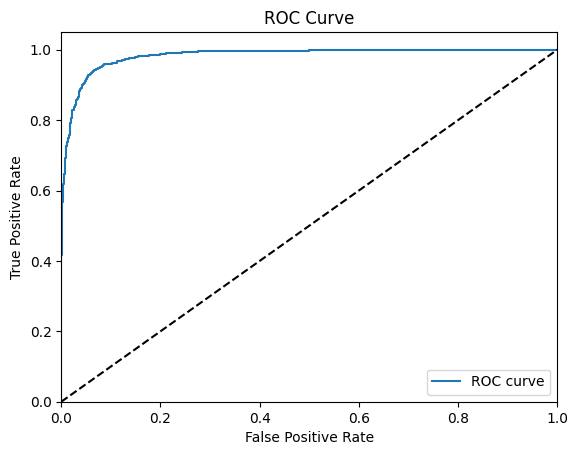

In [102]:
# let's plot the ROC curve to and calculate AUC score
fpr, tpr, thresholds = roc_curve(valid_labels, y_pred_probs)
auc = roc_auc_score(valid_labels, y_pred_probs)

print('AUC score = ', auc)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### Near perfect scores!
---

In [94]:
model.save_weights('my_weights.h5')

### 7.2) What's the prediction threshold that optimizes the F-1 score?

In [103]:
# given the ROC curve, which F1 score is the best and what recall and precision this corresponds to?
best_threshold = 0
best_f1 = 0
# calculate F1 score for each threshold and find the optimal threshold
for threshold in thresholds:
    y_pred = (y_pred_probs > threshold).astype(int)
    f1 = f1_score(valid_labels, y_pred)
    rec = recall_score(valid_labels, y_pred)
    acc = accuracy_score(valid_labels, y_pred)
    prec = precision_score(valid_labels, y_pred, zero_division=1)
    if f1 > best_f1:
        best_f1 = f1
        best_rec = rec
        best_prec = prec
        best_acc = acc
        best_threshold = threshold

print(f"Best Threshold = {best_threshold}")
print(f" --> Best F1 Score = {best_f1}")
print(f" --> Recall = {best_rec}")
print(f" --> Precision = {best_prec}")
print(f" --> Accuracy = {best_acc}")

Best Threshold = 0.1720428466796875
 --> Best F1 Score = 0.9345521023765997
 --> Recall = 0.9376375641966251
 --> Precision = 0.9314868804664723
 --> Accuracy = 0.9374563242487771


### 7.3) Confusion Matrix

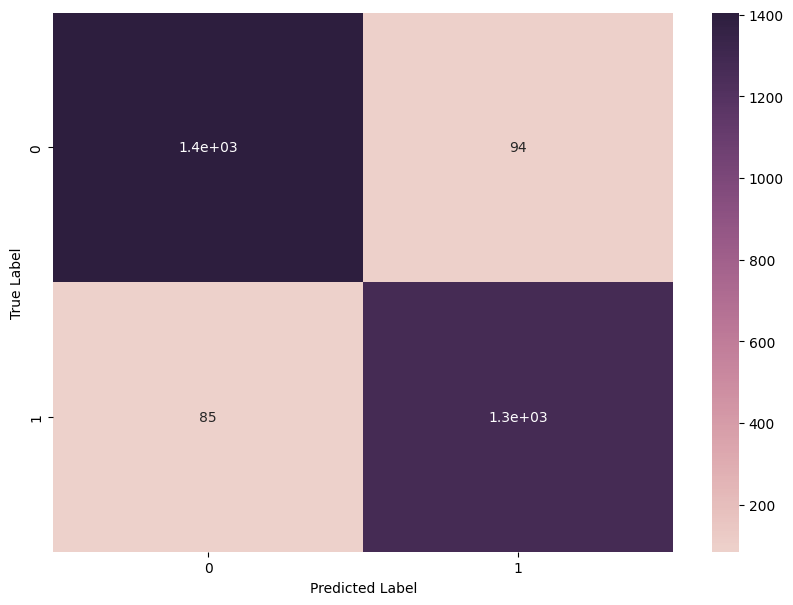

In [131]:
y_pred = (y_pred_probs > best_threshold).astype(int)
conf_matrix = confusion_matrix(valid_labels, y_pred)
labels = np.unique(y_pred)
df_cm = pd.DataFrame(conf_matrix, index = labels,
                  columns = labels)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap=sns.cubehelix_palette(as_cmap=True))
plt.xlabel('Predicted Label')
plt.ylabel('True Label');
